In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import pathlib
from collections import defaultdict
import os
import numpy as np
import random

In [2]:
def get_antipattern_dict(
    embedding_dir, ignore_dirs=[pathlib.Path('./embeddings/c_plus_plus/negative_samples')]
):
    antipatterns = list(embedding_dir.glob('*'))
    antipatterns_dict = {}
    for antipattern in antipatterns:
        if antipattern not in ignore_dirs:
            antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))
    return antipatterns_dict

def get_labels(antipatterns_dict):
    labels = defaultdict(lambda: [False, False, False, False, ''])
    name2label = {name: i for name, i in zip(antipatterns_dict, range(len(antipatterns_dict)))}
    label2name = {value: key for key, value in name2label.items()}
    for name, paths in antipatterns_dict.items():
        for path in paths:
            labels[os.path.basename(path)][name2label[name]] = True
            labels[os.path.basename(path)][-1] = path
    return labels, name2label, label2name

def get_embedding(filename):
    return np.array([float(x) for x in filename.open().read().split()])

def get_embeddings(labels):
    for name, values in labels.items():
        labels[name].append(get_embedding(values[-1]).reshape(384, -1))
    return labels

In [3]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

embedding_dir = pathlib.Path('./embeddings/c_plus_plus')
negative_samples_dir = pathlib.Path('./embeddings/c_plus_plus/negative_samples')
antipatterns_dict = get_antipattern_dict(embedding_dir)
labels, name2label, label2name = get_labels(antipatterns_dict)
_ = get_embeddings(labels)

In [4]:
negative_samples = random.sample(list(negative_samples_dir.glob('*')), 300)

In [5]:
for negative_sample in negative_samples:
    embedding = get_embedding(negative_sample).reshape(384, -1)
    labels[negative_sample.name] = [False, False, False, False, negative_sample, embedding]

In [6]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'data_class': 1,
 'god_class': 2,
 'feature_envy': 3}

In [7]:
pih = {file for file in labels.keys() if labels[file][0]}
gc = {file for file in labels.keys() if labels[file][1]}
dc = {file for file in labels.keys() if labels[file][2]}
fe = {file for file in labels.keys() if labels[file][3]}
ne = {file for file in labels.keys() if not any(labels[file][:4])}
sets = (ne, pih, gc, dc, fe)

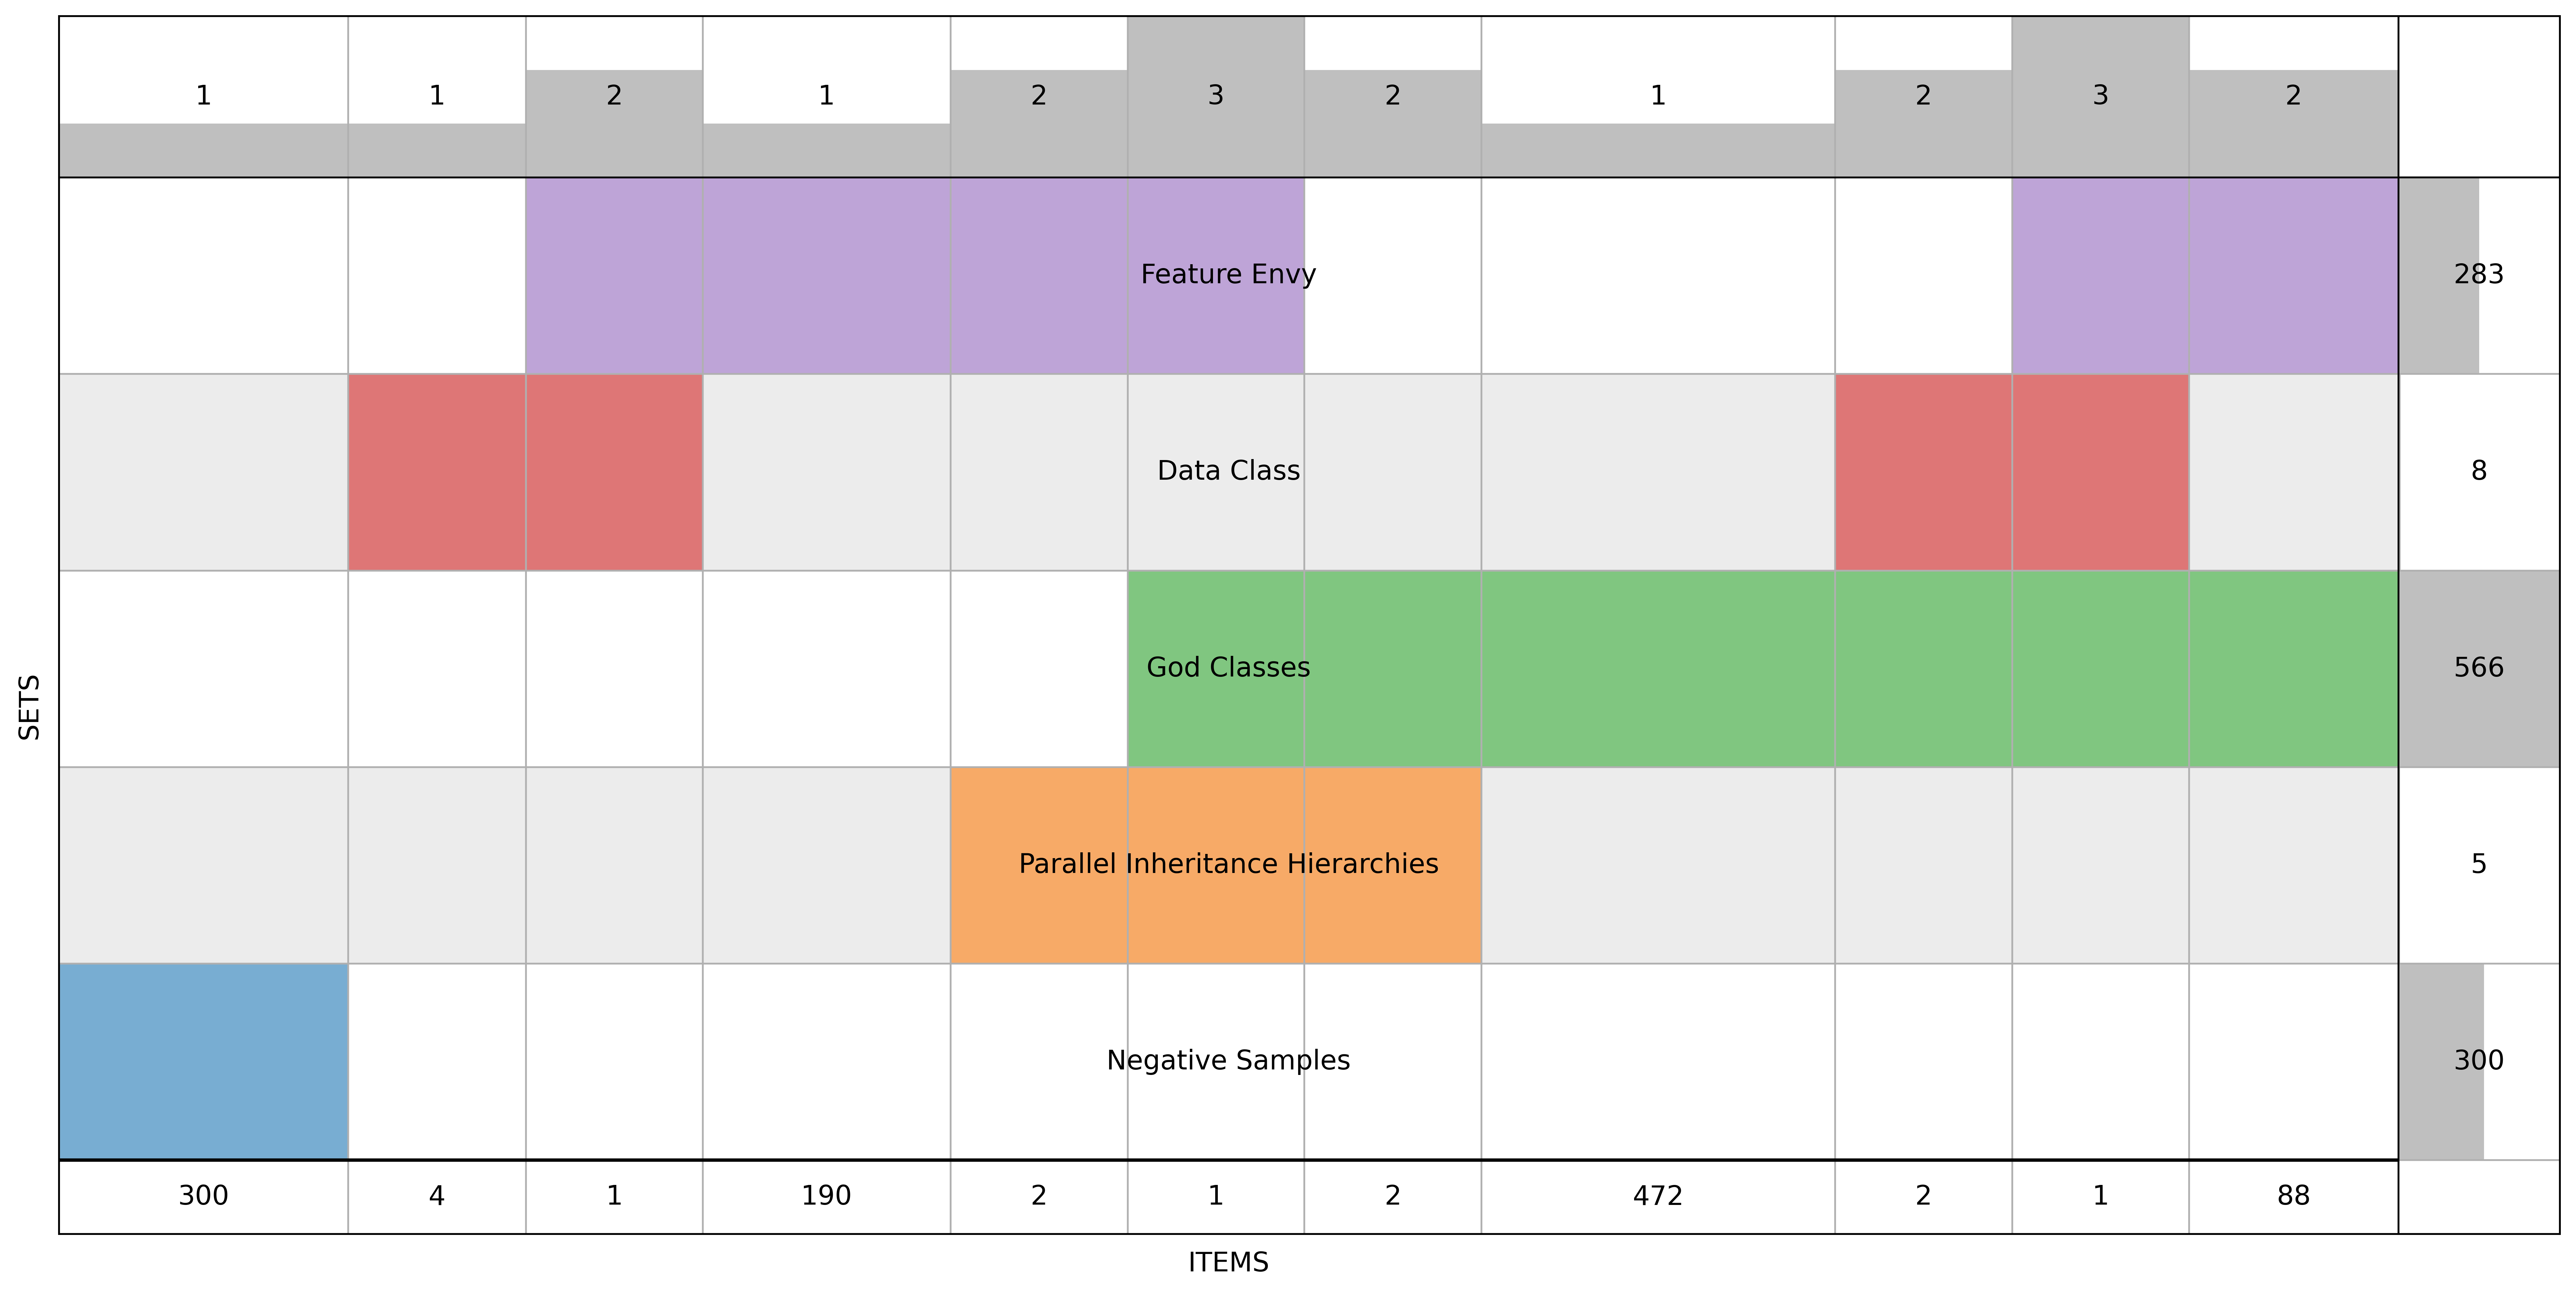

In [8]:
from supervenn import supervenn
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10), dpi=500)
l = ['Negative Samples', 'Parallel Inheritance Hierarchies', 'God Classes', 'Data Class', 'Feature Envy']
supervenn(sets, l, side_plots=True, widths_minmax_ratio=0.5)
plt.savefig('dataset.png')

In [9]:
len(labels)

1063

In [10]:
class PredictionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        conv_out_dim,
        lstm_hidden,
        n_labels,
        filter_size=3,
        drop_rate_conv=0.3,
        drop_rate_lstm=0.5,
    ):
        super(PredictionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_dim, conv_out_dim, filter_size, padding=filter_size // 2),
            nn.ReLU(),
            nn.Dropout(drop_rate_conv),
        )
        self.biLSTM = nn.LSTM(
            input_size=conv_out_dim, hidden_size=lstm_hidden, bidirectional=True, batch_first=True
        )
        self.out = nn.Linear(2 * lstm_hidden, n_labels)
        self.dropout = nn.Dropout(drop_rate_lstm)

    def forward(self, x):
        # Expected: Tensor([batch_size, conv_out_dim, max_seq])
        x = self.conv(x)
        x = self.dropout(x)
        # Expected: Tensor([batch_size, max_seq, conv_out_dim])
        x = x.permute(0, 2, 1)
        # Expected: Tensor([batch_size, max_seq, 2*hidden_size])
        outputs, (hn, cn) = self.biLSTM(x)
        cat = torch.cat([hn[0], hn[1]], dim=-1)
        res = self.out(self.dropout(cat))

        return res

In [11]:
class EmbeddingDataset(Dataset):
    def __init__(self, labels, names):
        self.labels = labels
        self.names = sorted(names, key=lambda x: self.labels[x][-1].shape[1])
        
    def __getitem__(self, idx):
        *labels, _, emb = self.labels[self.names[idx]]
        return torch.FloatTensor(emb), np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.names)

In [12]:
labels = {key:value for key, value in labels.items() if value != [False, False, '']}

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(list(labels.keys()), test_size=0.2, random_state=42)

In [14]:
def collate_fn(batch):
    max_sequence_len = max([x[0].shape[1] for x in batch])
    emb_dim = batch[0][0].shape[0]
    sequence_padded = torch.zeros([len(batch), emb_dim, max_sequence_len])
    ys = []
    for i, (X, y) in enumerate(batch):
        sequence_padded[i,:,:X.shape[-1]] = X
        ys.append(y)
    return sequence_padded, torch.Tensor(ys)

In [15]:
from sklearn.metrics import roc_curve
import numpy as np


def get_thresholds_multiclass(predictions, target):
    thresholds = []
    for i in range(predictions.shape[1]):
        fpr, tpr, threshes = roc_curve(target.T[i], predictions.T[i])
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        thresholds.append(threshes[ix])
    return thresholds


# Requires two tensors of size [batch_size, n_classes] and a vector of size [n_classes]
def get_accuracy_multiclass(predictions, target, thresholds=None):
    if thresholds is None:
        thresholds = get_thresholds_multiclass(predictions, target)
    predictions = predictions.T
    target = target.T
    correct = 0
    for i in range(predictions.shape[0]):
        predictions[i] = predictions[i] > thresholds[i]
        correct += np.sum(predictions[i] == target[i])
    return thresholds, correct / (predictions.shape[0] * predictions.shape[1])

In [16]:
def train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds):
    model.train()
    losses_train = []
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        model.zero_grad()
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        # compute metrics
        losses_train.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls), thresholds)
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Accuracy [{acc:.2f}]')
    return losses_train

In [17]:
def train_step(model, train_loader, loss_func, optimizer, device):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for X, y in pbar:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_train

In [18]:
def valid_step(model, valid_loader, loss_func, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    total_preds = []
    total_lbls = []
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        out = model(X)

        loss = loss_func(out, y)
        # make predictions
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)
        total_preds.append((torch.sigmoid(out) > 0.5).detach().cpu().numpy().astype(int))
        total_lbls.append(y.cpu().numpy())
    
        # compute metrics
        y = y.reshape(-1).cpu().numpy()
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)

        losses_valid.append(loss.item())
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    print(classification_report(np.vstack(total_lbls), np.vstack(total_preds)))
    return losses_valid

In [19]:
from sklearn.metrics import classification_report, f1_score
def valid_step_with_roc(model, train_loader, loss_func, device):
    losses_valid = []
    model.eval()
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)

        # compute metrics
        losses_valid.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Accuracy [{acc:.2f}]')
    preds = np.vstack(preds)
    thresholds, _ = get_accuracy_multiclass(preds, np.vstack(lbls))
    print(classification_report(np.vstack(lbls), preds))
    return losses_valid, thresholds

In [20]:
batch_size = 16
train_dataset = EmbeddingDataset(labels, train)
valid_dataset = EmbeddingDataset(labels, test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim = 384
conv_out_dim = 128
lstm_hidden = 128
n_labels = len(name2label)

lr = 1e-4
epochs = 16
loss_func = nn.BCEWithLogitsLoss()
thresholds = np.repeat(0.5, n_labels)

In [22]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [23]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'data_class': 1,
 'god_class': 2,
 'feature_envy': 3}

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      0.07      0.13       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.67      0.04      0.08       178
   macro avg       0.17      0.02      0.03       178
weighted avg       0.42      0.04      0.08       178
 samples avg       0.04      0.03      0.03       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.70       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.70       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.70       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.63      0.58       178
   macro avg       0.13      0.25      0.17       178
weighted avg       0.34      0.63      0.44       178
 samples avg       0.53      0.48      0.50       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.53      0.96      0.68       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.53      0.61      0.57       178
   macro avg       0.13      0.24      0.17       178
weighted avg       0.34      0.61      0.43       178
 samples avg       0.51      0.46      0.48       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.54      0.96      0.69       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.54      0.61      0.57       178
   macro avg       0.14      0.24      0.17       178
weighted avg       0.34      0.61      0.44       178
 samples avg       0.51      0.46      0.48       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.55      0.96      0.70       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.55      0.61      0.58       178
   macro avg       0.14      0.24      0.17       178
weighted avg       0.35      0.61      0.44       178
 samples avg       0.51      0.46      0.48       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.55      0.95      0.70       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.55      0.60      0.58       178
   macro avg       0.14      0.24      0.17       178
weighted avg       0.35      0.60      0.44       178
 samples avg       0.50      0.46      0.47       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.54      0.87      0.67       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.54      0.55      0.55       178
   macro avg       0.14      0.22      0.17       178
weighted avg       0.34      0.55      0.42       178
 samples avg       0.46      0.41      0.43       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.55      0.80      0.65       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.55      0.51      0.53       178
   macro avg       0.14      0.20      0.16       178
weighted avg       0.35      0.51      0.41       178
 samples avg       0.42      0.38      0.39       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.55      0.79      0.64       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.55      0.50      0.52       178
   macro avg       0.14      0.20      0.16       178
weighted avg       0.35      0.50      0.41       178
 samples avg       0.42      0.37      0.39       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.54      0.79      0.64       113
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        61

   micro avg       0.54      0.50      0.52       178
   macro avg       0.14      0.20      0.16       178
weighted avg       0.34      0.50      0.41       178
 samples avg       0.42      0.37      0.39       178



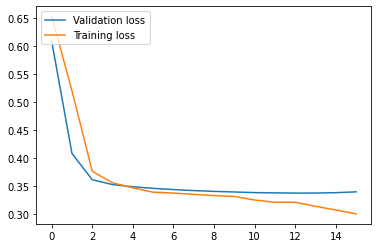

In [24]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step(model, train_loader, loss_func, optimizer, device)
    losses_valid = valid_step(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

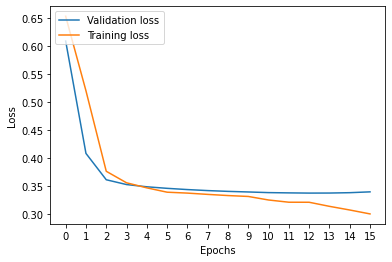

In [25]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('python-lstm-14-epochs.png', dpi=300)
plt.show()

In [26]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [27]:
thresholds

array([0.5, 0.5, 0.5, 0.5])

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.66      0.41      0.50       113
           2       0.01      0.50      0.02         2
           3       0.36      0.57      0.44        61

   micro avg       0.25      0.47      0.33       178
   macro avg       0.26      0.50      0.25       178
weighted avg       0.54      0.47      0.47       178
 samples avg       0.15      0.33      0.19       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.63      0.37      0.47       113
           2       0.00      0.00      0.00         2
           3       0.26      0.43      0.32        61

   micro avg       0.23      0.39      0.29       178
   macro avg       0.22      0.32      0.20       178
weighted avg       0.49      0.39      0.41       178
 samples avg       0.13      0.26      0.16       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.64      0.43      0.52       113
           2       0.00      0.00      0.00         2
           3       0.31      0.52      0.39        61

   micro avg       0.26      0.46      0.33       178
   macro avg       0.24      0.36      0.23       178
weighted avg       0.51      0.46      0.46       178
 samples avg       0.16      0.32      0.21       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.01      0.50      0.03         2
           1       0.70      0.40      0.51       113
           2       0.00      0.00      0.00         2
           3       0.36      0.67      0.47        61

   micro avg       0.29      0.49      0.36       178
   macro avg       0.27      0.39      0.25       178
weighted avg       0.57      0.49      0.48       178
 samples avg       0.21      0.34      0.24       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.70      0.39      0.50       113
           2       0.00      0.00      0.00         2
           3       0.38      0.67      0.49        61

   micro avg       0.32      0.48      0.38       178
   macro avg       0.27      0.39      0.25       178
weighted avg       0.57      0.48      0.49       178
 samples avg       0.22      0.33      0.24       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.60      0.64      0.62       113
           2       0.00      0.00      0.00         2
           3       0.38      0.67      0.49        61

   micro avg       0.37      0.64      0.47       178
   macro avg       0.25      0.45      0.28       178
weighted avg       0.51      0.64      0.56       178
 samples avg       0.25      0.45      0.31       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.61      0.53      0.57       113
           2       0.00      0.00      0.00         2
           3       0.38      0.67      0.49        61

   micro avg       0.37      0.57      0.45       178
   macro avg       0.25      0.43      0.27       178
weighted avg       0.52      0.57      0.53       178
 samples avg       0.24      0.40      0.29       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.62      0.52      0.57       113
           2       0.00      0.00      0.00         2
           3       0.38      0.67      0.49        61

   micro avg       0.37      0.57      0.45       178
   macro avg       0.26      0.42      0.27       178
weighted avg       0.53      0.57      0.53       178
 samples avg       0.25      0.40      0.29       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.61      0.58      0.59       113
           2       0.00      0.00      0.00         2
           3       0.38      0.67      0.49        61

   micro avg       0.38      0.60      0.47       178
   macro avg       0.25      0.44      0.28       178
weighted avg       0.52      0.60      0.54       178
 samples avg       0.26      0.43      0.31       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.62      0.62      0.62       113
           2       0.01      0.50      0.02         2
           3       0.37      0.67      0.48        61

   micro avg       0.30      0.63      0.40       178
   macro avg       0.26      0.57      0.29       178
weighted avg       0.52      0.63      0.56       178
 samples avg       0.23      0.45      0.29       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.63      0.59      0.61       113
           2       0.01      0.50      0.02         2
           3       0.37      0.67      0.48        61

   micro avg       0.29      0.62      0.40       178
   macro avg       0.26      0.57      0.29       178
weighted avg       0.53      0.62      0.55       178
 samples avg       0.22      0.44      0.27       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.62      0.62      0.62       113
           2       0.01      0.50      0.02         2
           3       0.37      0.67      0.48        61

   micro avg       0.30      0.63      0.41       178
   macro avg       0.26      0.57      0.29       178
weighted avg       0.52      0.63      0.56       178
 samples avg       0.22      0.45      0.28       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.62      0.53      0.57       113
           2       0.01      0.50      0.02         2
           3       0.37      0.66      0.47        61

   micro avg       0.28      0.57      0.38       178
   macro avg       0.26      0.55      0.28       178
weighted avg       0.52      0.57      0.53       178
 samples avg       0.19      0.40      0.24       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.63      0.62      0.62       113
           2       0.01      0.50      0.02         2
           3       0.38      0.75      0.50        61

   micro avg       0.31      0.66      0.42       178
   macro avg       0.26      0.59      0.30       178
weighted avg       0.53      0.66      0.57       178
 samples avg       0.26      0.47      0.31       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.63      0.65      0.64       113
           2       0.01      0.50      0.02         2
           3       0.37      0.75      0.49        61

   micro avg       0.31      0.69      0.43       178
   macro avg       0.26      0.60      0.30       178
weighted avg       0.52      0.69      0.58       178
 samples avg       0.27      0.49      0.33       178



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.62      0.64      0.63       113
           2       0.01      0.50      0.02         2
           3       0.38      0.61      0.47        61

   micro avg       0.31      0.62      0.41       178
   macro avg       0.26      0.56      0.29       178
weighted avg       0.53      0.62      0.56       178
 samples avg       0.23      0.45      0.29       178



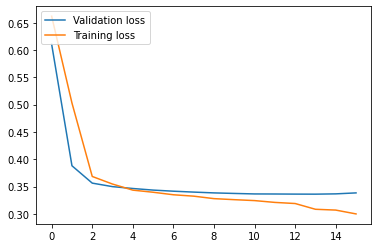

In [28]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds)
    losses_valid, thresholds  = valid_step_with_roc(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

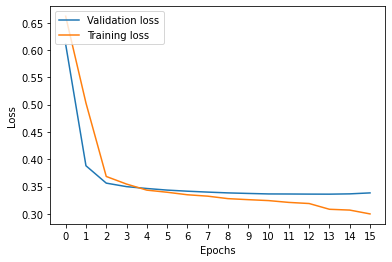

In [29]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('cplusplus_lstm-16-epochs_with_roc_curve.png', dpi=300)
plt.show()